# Measure skew-spectra of DM in redshift space --version 3#

In [1]:
from __future__ import print_function, division


%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from nbodykit import style

import matplotlib.pyplot as plt
import numpy as np
import os
from collections import OrderedDict
from scipy.interpolate import interp1d

from nbodykit.lab import FFTPower, FieldMesh
from nbodykit import CurrentMPIComm

from lsstools.cosmo_model import CosmoModel
from lsstools.gen_cosmo_fcns import calc_f_log_growth_rate, generate_calc_Da
from lsstools.paint_utils import mass_weighted_paint_cat_to_delta
from perr.path_utils import get_in_path
from lsstools.nbkit03_utils import get_csum, get_csqsum, apply_smoothing, catalog_persist, get_cstats_string, linear_rescale_fac, get_crms,convert_nbk_cat_to_np_array
from perr_private.model_target_pair import ModelTargetPair, Model, Target
from lsstools.sim_galaxy_catalog_creator import PTChallengeGalaxiesFromRockstarHalos
from perr_private.read_utils import readout_mesh_at_cat_pos

from skewspec import smoothing
from skewspec.skew_spectrum import SkewSpectrumV2, QuadField, SumOfQuadFields, LinField, compute_dnm, compute_dnm_dnmprime

plt.style.use(style.notebook)
colors = [d['color'] for d in style.notebook['axes.prop_cycle']]

## Global params ##

In [2]:
opts = OrderedDict()

opts['code_version_for_outputs'] = '0.1'

theo_basedir = '../data/azadeh_08sep2020/'


opts['sim_seed'] = 400
opts['boxsize'] = 1500.
basedir = os.path.expandvars('$SCRATCH/lss/ms_gadget/run4/00000%d-01536-%.1f-wig/' % (
    opts['sim_seed'], opts['boxsize']))
opts['sim_scale_factor'] = 0.625
opts['Rsmooth'] = 20.0
opts['Ngrid'] = 256
opts['LOS'] = np.array([0,0,1])
opts['APPLY_RSD'] = True
opts['subsample_ratio'] = 0.0015
opts['max_displacement'] = 20.0

# which multipoles (ell) to compute
opts['poles'] = [0,2]

# Source from which to compute density: 'cat' or 'delta_2SPT'
opts['density_source'] = 'delta_2SPT'

# more options if source is catalog
if opts['density_source'] == 'catalog':
    # Catalog with particle positions: 'DM_subsample' or 'gal_ptchall_with_RSD'
    opts['positions_catalog'] = 'DM_subsample'
    # Velocity source: DM_sim, deltalin_D2, deltalin_D2_2SPT
    opts['velocity_source'] = 'DM_sim'

elif opts['density_source'] == 'delta_2SPT':
    opts['positions_catalog'] = None
    opts['velocity_source'] = None
else:
    raise Exception('Invalid density_source %s' % opts['density_source'])



In [3]:


# where to save output
DS_string = '_DS%s' % opts['density_source']
if opts['density_source'] == 'cat':
    sr_string = '_sr%g' % opts['subsample_ratio']
    vel_string = '_v%s' % opts['velocity_source']
    MD_string = '_MD%g' % opts['max_displacement']
else:
    sr_string, vel_string, MD_string = '', '', ''

opts['outdir'] = 'data/Pskew_sims/00000%d-01536-%.1f-wig/R%.1f_Ng%d_RSD%d%s%s%s%s/' % (
    opts['sim_seed'], opts['boxsize'], opts['Rsmooth'], opts['Ngrid'],
    int(opts['APPLY_RSD']), 
    DS_string, sr_string, vel_string, MD_string)




# cosmology of ms_gadget sims (to compute D_lin(z))
# omega_m = 0.307494
# omega_bh2 = 0.022300
# omega_ch2 = 0.118800
# h = math.sqrt((omega_bh2 + omega_ch2) / omega_m) = 0.6774
opts['cosmo_params'] = dict(Om_m=0.307494,
                   Om_L=1.0 - 0.307494,
                   Om_K=0.0,
                   Om_r=0.0,
                   h0=0.6774)

opts['f_log_growth'] = np.sqrt(0.61826)


Nmesh = opts['Ngrid']
BoxSize = np.array([opts['boxsize'], opts['boxsize'], opts['boxsize']])
comm = CurrentMPIComm.get()
LOS = opts['LOS']
LOS_string = 'LOS%d%d%d' % (LOS[0], LOS[1], LOS[2])


# Below, 'D' stands for RSD displacement in Mpc/h: D=v/(aH)=f*PsiDot.


### Catalogs

# DM subsample
if opts['subsample_ratio'] != 1.0:
    DM_subsample = Target(
        name='DM_subsample',
        in_fname=os.path.join(basedir, 'snap_%.4f_sub_sr%g_ssseed40%d.bigfile' % (
            opts['sim_scale_factor'], opts['subsample_ratio'], opts['sim_seed'])),
        position_column='Position'
    )
else:
    # full DM sample
    DM_subsample = Target(
        name='DM_subsample',
        in_fname=os.path.join(basedir, 'snap_%.4f' % (
            opts['sim_scale_factor'])),
        position_column='Position'
    )


# DM_D2 = Target(
#     name='DM_D2',
#     in_fname=os.path.join(basedir, 'snap_%.4f_sub_sr0.0015_ssseed40%d.bigfile' % (
#         opts['sim_scale_factor'], opts['sim_seed'])),
#     position_column='Position',
#     val_column='Velocity',
#     val_component=2,
#     rescale_factor='RSDFactor'
# )

if False:
    # PT Challenge galaxies from rockstar halos. Rockstar gives core positions and velocities.
    # Units: 1/(aH) = 1./(a * H0*np.sqrt(Om_m/a**3+Om_L)) * (H0/100.) in Mpc/h / (km/s).
    # For ms_gadget, get 1/(aH) = 0.01145196 Mpc/h/(km/s) = 0.0183231*0.6250 Mpc/h/(km/s).
    # Note that MP-Gadget files have RSDFactor=1/(a^2H)=0.0183231 for a=0.6250 b/c they use a^2\dot x for Velocity.
    assert opts['sim_scale_factor'] == 0.625

    # PT challenge galaxies, apply RSD to position (TEST)
    assert opts['sim_scale_factor'] == 0.625
    gal_ptchall_with_RSD = Target(
        name='gal_ptchall_with_RSD',
        in_fname=os.path.join(basedir, 'snap_%.4f.gadget3/rockstar_out_0.list.parents.bigfile' % opts['sim_scale_factor']),
        position_column='Position',
        velocity_column='Velocity', 
        apply_RSD_to_position=True,
        RSD_los=LOS,
        RSDFactor=0.01145196,
        #val_column='Velocity', # This is rockstar velocity, which is v=a\dot x in km/s ("Velocities in km / s (physical, peculiar)")
        #val_component=0,
        #rescale_factor=0.01145196, # RSD displacement in Mpc/h is D=v/(aH)=0.01145196*v. 
        cuts=[PTChallengeGalaxiesFromRockstarHalos(
                log10M_column='log10Mvir', log10Mmin=12.97, sigma_log10M=0.35, RSD=False),
              #('Position', 'max', [100.,100.,20.])
             ]
        )


### Densities

# Linear density
z_rescalefac = linear_rescale_fac(current_scale_factor=1.0,
                                  desired_scale_factor=opts['sim_scale_factor'],
                                  cosmo_params=opts['cosmo_params'])
print('z_rescalefac:', z_rescalefac)
deltalin = Model(
    name='deltalin',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % opts['Ngrid']),
    rescale_factor=z_rescalefac,
    read_mode='delta from 1+delta',
    filters=None,
    readout_window='cic')

# Linear RSD displacement
def k2ovksq_filter_fcn(k, v, d=2):
    ksq = sum(ki**2 for ki in k)
    return np.where(ksq == 0.0, 0*v, 1j*k[d] * v / (ksq))
deltalin_D2 = Model(
    name='deltalin_D2',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % opts['Ngrid']),
    rescale_factor=opts['f_log_growth']*z_rescalefac,
    read_mode='delta from 1+delta',
    filters=[k2ovksq_filter_fcn],
    readout_window='cic')

# 2nd order SPT displacement: ik/k^2*G2
deltalin_D2_2ndorderSPTcontri = Model(
    name='deltalin_D2_2ndorderSPTcontri',
    in_fname=os.path.join(basedir, 'IC_LinearMesh_z0_Ng%d' % opts['Ngrid']),
    rescale_factor=opts['f_log_growth']*z_rescalefac,
    read_mode='delta from 1+delta',
    filters=[k2ovksq_filter_fcn],
    readout_window='cic')

z_rescalefac: 0.7336055475440896


## Read and plot Azadeh theory ##

In [4]:
Ptheo = np.genfromtxt(os.path.join(theo_basedir, 'p_deltadelta.txt'), names=True)

In [5]:
Ptheo.dtype

dtype([('k', '<f8'), ('P_link', '<f8'), ('P_0k', '<f8'), ('P_2k', '<f8'), ('P_4k', '<f8')])

In [6]:
Rsmooth = opts['Rsmooth']
realnames = ['k'] + ['S%dp_lin' %d for d in range(1,15)]
Sn_real_theo = np.genfromtxt(os.path.join(theo_basedir, 'Sn_real_R%d.txt' % int(Rsmooth)), names=realnames)
Sn_rsd_theo = OrderedDict()
for ell in [0,2,4]:
    rsdnames = ['k'] + ['S%d' % d for d in range(1,15)]
    Sn_rsd_theo[(ell,)] = np.genfromtxt(os.path.join(theo_basedir, 'Sn_rsd_%d_R%d.txt' % (ell,int(Rsmooth))), names=rsdnames)
    print(Sn_rsd_theo[(ell,)].dtype.names)

('k', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14')
('k', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14')
('k', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14')


In [7]:
print(Sn_real_theo.dtype.names)

('k', 'S1p_lin', 'S2p_lin', 'S3p_lin', 'S4p_lin', 'S5p_lin', 'S6p_lin', 'S7p_lin', 'S8p_lin', 'S9p_lin', 'S10p_lin', 'S11p_lin', 'S12p_lin', 'S13p_lin', 'S14p_lin')


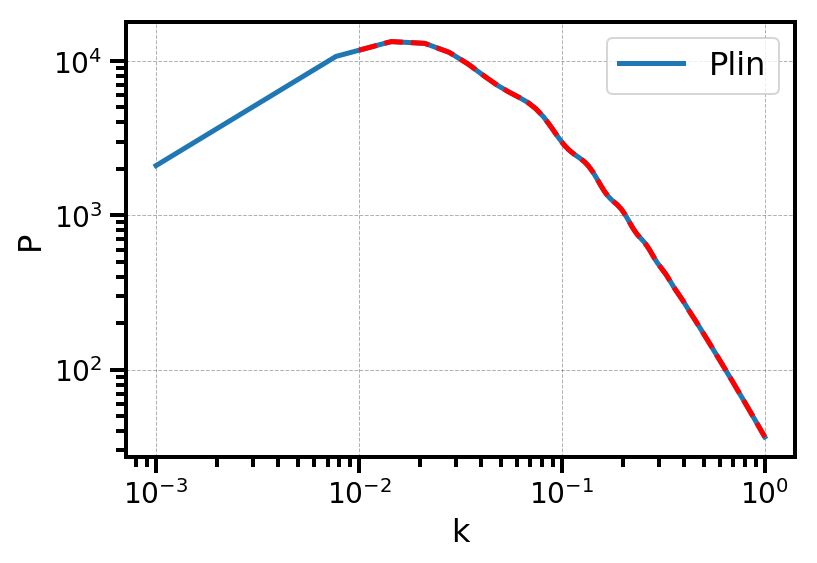

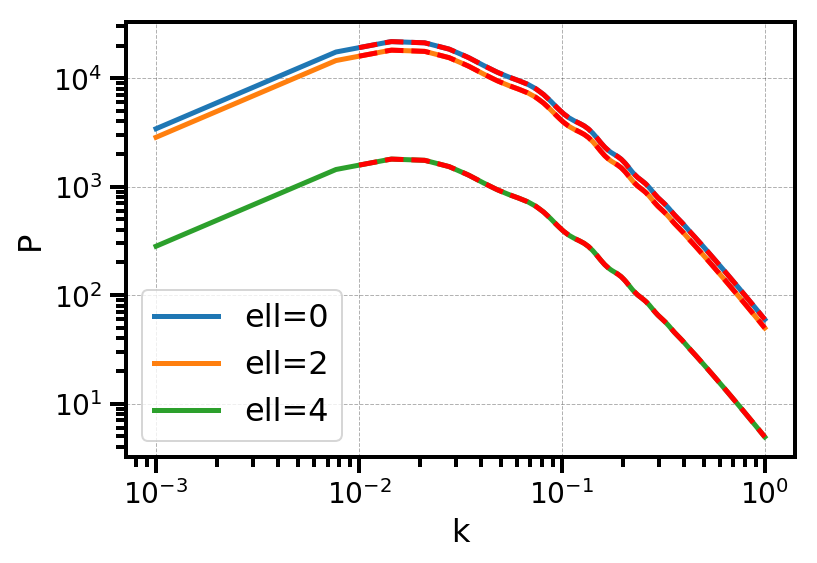

In [8]:
# plot Plin azadeh
# interp_lnPtheo_lnk = OrderedDict()
# interp_Ptheo_k = OrderedDict()
# for key in Ptheo.dtype.names:
#     if key == 'k':
#         continue
#     interp_lnPtheo_lnk[key] = interp1d(np.log(Ptheo['k']), np.log(Ptheo[key]))
#     interp_Ptheo_k[key] = lambda k: np.exp(interp_lnPtheo_lnk[key](np.log(k)))
    
interp_lnPtheo_lnk_Plin = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_link']))
interp_Ptheo_k_Plin = lambda k: np.exp(interp_lnPtheo_lnk_Plin(np.log(k)))
interp_lnPtheo_lnk_P0 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_0k']))
interp_Ptheo_k_P0 = lambda k: np.exp(interp_lnPtheo_lnk_P0(np.log(k)))
interp_lnPtheo_lnk_P2 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_2k']))
interp_Ptheo_k_P2 = lambda k: np.exp(interp_lnPtheo_lnk_P2(np.log(k)))
interp_lnPtheo_lnk_P4 = interp1d(np.log(Ptheo['k']), np.log(Ptheo['P_4k']))
interp_Ptheo_k_P4 = lambda k: np.exp(interp_lnPtheo_lnk_P4(np.log(k)))


# plot Plin
plt.subplots(figsize=(6,4))
plt.loglog(Ptheo['k'], Ptheo['P_link'], label='Plin')
kvec = np.logspace(-2,0,100)
plt.loglog(kvec, interp_Ptheo_k_Plin(kvec), 'r--')
plt.legend();
plt.ylabel('P'); plt.xlabel('k');

# Plot multipole power spectra azadeh
plt.subplots(figsize=(6,4))
for ell in [0,2,4]:
    plt.loglog(Ptheo['k'], Ptheo['k']**0*Ptheo['P_%dk' % ell], label='ell=%d'%ell)
    if ell==0:
        plt.loglog(kvec, interp_Ptheo_k_P0(kvec), 'r--')
    elif ell==2:
        plt.loglog(kvec, interp_Ptheo_k_P2(kvec), 'r--')
    elif ell==4:
        plt.loglog(kvec, interp_Ptheo_k_P4(kvec), 'r--')
plt.legend();
plt.ylabel('P'); plt.xlabel('k');




In [9]:
# PLot real space theory S_n from azadeh
if False:
    fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)
    for counter, n in enumerate(range(1,15)):
        ax = axarr[counter%7,counter//7]
        ax.semilogx(Sn_real_theo['k'], Sn_real_theo['S%dp_lin'%n])
        ax.set_ylabel(r'$S^\mathregular{real}_{%d}/P_\mathregular{lin}$' % n)
    axarr[6,0].set_xlabel('k')
    axarr[6,1].set_xlabel('k')
    plt.tight_layout()

In [10]:
# PLot RSD theory S_n from azadeh
if False:
    fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)
    for counter, n in enumerate(range(1,15)):
        ax = axarr[counter%7,counter//7]
        for ell in [0,2]:
            ax.semilogx(Sn_rsd_theo[(ell,)]['k'], Sn_rsd_theo[(ell,)]['S%d'%n], label=r'$\ell=%d$'%ell)
        ax.set_ylabel(r'$S^{(\ell)}_{%d}/P_\ell$' % n)
        ax.legend(loc='best')
    axarr[6,0].set_xlabel('k')
    axarr[6,1].set_xlabel('k')
    plt.tight_layout()

## Compute densities and spectra ##

In [11]:
compute_112_manually = False

if opts['density_source'] == 'delta_2SPT':
    # compute 2nd order density from linear mesh
    if comm.rank == 0:
        print('Warning: Not smoothing when generating 2nd order field')

    if not opts['APPLY_RSD']:
        # Compute delta1 + F2[delta1]
        deltalin_mesh = deltalin.get_mesh()
        delta_mesh = FieldMesh(
            deltalin.get_mesh().compute()
            + QuadField(composite='F2').compute_from_mesh(deltalin.get_mesh()).compute(mode='real')
            )
    else:
        # compute 2nd order density in redshift space
        b1, b2, bG2 = 1.0, 0.0, 0.0
        f = opts['f_log_growth']
        if compute_112_manually:
            # delta_mesh = delta_2
            first_order_fac = 0
        else:
            # delta_mesh= delta_1 + delta_2
            first_order_fac = 1
        delta_mesh = FieldMesh(
            first_order_fac * (
                b1 * deltalin.get_mesh().compute()
                + f * LinField(m=2*LOS, n=-2).compute_from_mesh(deltalin.get_mesh()).compute()
            )
            + 1 * b1 * QuadField(composite='F2').compute_from_mesh(deltalin.get_mesh()).compute()
            + 1 * (     
                    f * QuadField(composite=('velocity_G2_par_%s' % LOS_string)).compute_from_mesh(deltalin.get_mesh()).compute(mode='real')
                    + b1 * f * QuadField(nprime=-2, mprime=LOS, mprimeprime=LOS).compute_from_mesh(deltalin.get_mesh()).compute()
                    #+ f**2 * QuadField(n=-2, m=2*LOS, nprime=-2, mprime=LOS, mprimeprime=LOS).compute_from_mesh(deltalin.get_mesh()).compute()
                    + 0.5*f**2 * QuadField(n=-2, m=LOS, nprime=-2, mprime=LOS, mprimeprime=2*LOS).compute_from_mesh(deltalin.get_mesh()).compute()
                   )
        )

        # linear piece
        deltalin_mesh = FieldMesh( 
            b1 * deltalin.get_mesh().compute()
            + f * LinField(m=2*LOS, n=-2).compute_from_mesh(deltalin.get_mesh()).compute() )



        if b2 != 0.:
            delta_mesh = FieldMesh(
                delta_mesh.compute()
                + b2/2.0 * QuadField().compute_from_mesh(deltalin.get_mesh()).compute())

        if bG2 != 0.0:
            delta_mesh = FieldMesh(
                delta_mesh.compute()
                + bG2 * QuadField(composite='tidal_G2').compute_from_mesh(deltalin.get_mesh()).compute())




elif opts['density_source'] == 'catalog':

    ##########################################################################
    # Get DM catalog in redshift space (if APPLY_RSD==True) 
    ##########################################################################

    # get the catalog
    if opts['positions_catalog'] == 'gal_ptchall_with_RSD':
        target = gal_ptchall_with_RSD
    elif opts['positions_catalog'] == 'DM_subsample':
        target = DM_subsample
    cat = target.get_catalog(keep_all_columns=True)

    if comm.rank == 0:
        print('Positions catalog:')
        print(cat.attrs)

    # add redshift space positions, assuming LOS is in z direction
    if opts['velocity_source'] == 'DM_sim':
        # use DM velocity
        displacement = cat['Velocity']*cat.attrs['RSDFactor'] * opts['LOS']
        displacement = displacement.compute()
        if opts['max_displacement'] is not None:
            ww = np.where(np.linalg.norm(displacement, axis=1)>opts['max_displacement'])[0]
            print(r'%d: max_displacement=%g. Set velocity to 0 for %g percent of particles' % (
                comm.rank, opts['max_displacement'], 100.*float(len(ww)/displacement.shape[0])))
            displacement[ww,0] *= 0
            displacement[ww,1] *= 0
            displacement[ww,2] *= 0
        cat['RSDPosition'] = cat['Position'] + displacement


    elif opts['velocity_source'] in ['deltalin_D2', 'deltalin_D2_2SPT']:

        if opts['velocity_source'] == 'deltalin_D2':
            print('Warning: linear velocity does not have 2nd order G2 velocity, so expect wrong bispectrum')

        assert np.all(opts['LOS'] == np.array([0,0,1]))
        mtp = ModelTargetPair(model=deltalin_D2, target=DM_subsample)
        cat['RSDPosition'] = cat['Position'].compute()

        # read out model at each catalog position on current rank.
        model_at_target_pos = mtp.readout_model_at_target_pos()
        mat = np.zeros((model_at_target_pos.size,3))
        assert np.all(opts['LOS'] == np.array([0,0,1]))
        mat[:,2] = model_at_target_pos
        cat['RSDPosition'] += mat


        if opts['velocity_source'] == 'deltalin_D2_2SPT':
            # add 2nd order G2 contribution to velocity
            raise Exception('todo')

    else:
        raise Exception('Invalid velocity_source: %s' % str(opts['velocity_source']))

    if comm.rank == 0:
        print('rms RSD displacement: %g Mpc/h' % np.mean((cat['Position'].compute()-cat['RSDPosition'].compute())**2)**0.5)
        print('max RSD displacement: %g Mpc/h' % np.max(np.abs(cat['Position'].compute()-cat['RSDPosition'].compute())))


    # Get redshift space catalog
    RSDcat = catalog_persist(cat, columns=['ID','PID','Position','RSDPosition','Velocity', 'log10Mvir'])
    del cat
    if opts['APPLY_RSD']:
        if comm.rank == 0:
            print('Applying RSD')
        RSDcat['Position'] = RSDcat['RSDPosition']
    else:
        if comm.rank == 0:
            print('Not applying RSD')

    # paint to mesh
    delta_mesh = FieldMesh(RSDcat.to_mesh(Nmesh=Nmesh, BoxSize=BoxSize, 
                window='cic', interlaced=False, compensated=False).compute()-1)

    if comm.rank == 0:
       print('# objects: Original: %d' % (RSDcat.csize))


else:
    raise Exception('Invalid density_source %s' % opts['density_source'])



##########################################################################
# Calculate power spectrum multipoles 
##########################################################################
def calc_power(mesh, second=None, mode='1d', k_bin_width=1.0, verbose=False, los=None, poles=None):
    BoxSize = mesh.attrs['BoxSize']
    assert BoxSize[0] == BoxSize[1]
    assert BoxSize[0] == BoxSize[2]
    boxsize = BoxSize[0]
    dk = 2.0 * np.pi / boxsize * k_bin_width
    kmin = 2.0 * np.pi / boxsize / 2.0

    if mode == '1d':
        res = FFTPower(first=mesh,
                        second=second,
                        mode=mode,
                        dk=dk,
                        kmin=kmin)
    elif mode == '2d':
        if poles is None:
            poles = [0,2,4]
        res = FFTPower(first=mesh,
                            second=second,
                            mode=mode,
                            dk=dk,
                            kmin=kmin,
                            poles=poles,
                            Nmu=5,
                            los=los)
    else:
        raise Exception("Mode not implemented: %s" % mode)

    return res



#if comm.rank == 0:
#    print('Mesh: ', get_cstats_string(delta_mesh.compute()))

## Compute density power spectrum 
Pdd = calc_power(delta_mesh, los=opts['LOS'], mode='2d', poles=opts['poles'])


##########################################################################
# Get all RSD skew spectra
##########################################################################

# apply smoothing
smoothers = [smoothing.GaussianSmoother(R=opts['Rsmooth'])]
delta_mesh_smoothed = FieldMesh(delta_mesh.compute(mode='real'))
deltalin_mesh_smoothed = FieldMesh(deltalin_mesh.compute(mode='real'))
for smoother in smoothers:
    delta_mesh_smoothed = smoother.apply_smoothing(delta_mesh_smoothed)
    deltalin_mesh_smoothed = smoother.apply_smoothing(deltalin_mesh_smoothed)

#if comm.rank == 0:        
#    print('delta: ', get_cstats_string(delta_mesh.compute(mode='real')))
#    print('delta smoothed: ', get_cstats_string(delta_mesh_smoothed.compute(mode='real')))




# Define skew spectra. default n=n'=0 and m=m'=[0,0,0].
s1 = SkewSpectrumV2(QuadField(composite='F2'), LOS=LOS, name='S1')
s2 = SkewSpectrumV2(QuadField(), LOS=LOS, name='S2')
s3 = SkewSpectrumV2(QuadField(composite='tidal_G2'), LOS=LOS, name='S3')
s4a = SkewSpectrumV2(QuadField(nprime=-2,mprime=2*LOS), LOS=LOS, name='S4a')
s4b = SkewSpectrumV2(QuadField(m=LOS,nprime=-2,mprime=LOS), LOS=LOS, name='S4b')
s4split = SkewSpectrumV2(
    SumOfQuadFields(quad_fields=[
        QuadField(nprime=-2, mprime=2*LOS, prefactor=1.0), 
        QuadField(m=LOS, nprime=-2, mprime=LOS, prefactor=1.0)]),
    LOS=LOS, name='S4')
s4swap = SkewSpectrumV2(
    quad=QuadField(m=LOS, nprime=-2, mprime=LOS, prefactor=1.0),
    LOS=LOS, name='S4')
s4 = SkewSpectrumV2(
    quad=QuadField(nprime=-2, mprime=LOS, mprimeprime=LOS, prefactor=1.0),
    LOS=LOS, name='S4')
s4out = SkewSpectrumV2(
    quad=QuadField(nprime=-2, mprime=LOS, prefactor=1.0),
    lin=LinField(m=LOS),
    LOS=LOS, name='S4')
s4alternative = SkewSpectrumV2(
    quad=QuadField(m=LOS, nprime=-2, mprime=LOS, prefactor=1.0),
    LOS=LOS, name='S4')
s4alternative2 = SkewSpectrumV2(
    quad=SumOfQuadFields(quad_fields=[
        QuadField(m=LOS, nprime=-2, mprime=LOS, prefactor=2.0),
        QuadField(nprime=-2, mprime=LOS, mprimeprime=LOS, prefactor=1.0)]),
    LOS=LOS, name='S4')
# s4sep = SkewSpectrumV2(
#     quad=QuadField(nprime=-2, mprime=LOS),
#     lin=LinField(m=LOS),
#     LOS=LOS, name='S4sep')

# added factor of 2 on 11 sep 2020
s5 = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
    QuadField(composite='F2', nprime=-2, mprime=2*LOS, prefactor=2.0),
    QuadField(composite='velocity_G2_par_%s' % LOS_string)
]), LOS=LOS, name='S5')
s6 = SkewSpectrumV2(QuadField(nprime=-2, mprime=2*LOS), LOS=LOS, name='S6')
s7 = SkewSpectrumV2(QuadField(nprime=-2, mprime=2*LOS, composite='tidal_G2'), LOS=LOS, name='S7')
s8split = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
    QuadField(nprime=-4, mprime=4*LOS),
    QuadField(n=-2, m=2*LOS, nprime=-2, mprime=2*LOS, prefactor=2.0),
    QuadField(m=LOS, nprime=-4, mprime=3*LOS),
    QuadField(n=-2, m=3*LOS, nprime=-2, mprime=LOS, prefactor=2.0)]), LOS=LOS, name='S8split')
fudge_fac = 1.0
s8 = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
    QuadField(nprime=-4, mprime=3*LOS, mprimeprime=LOS, prefactor=fudge_fac),
    QuadField(n=-2, m=LOS, nprime=-2, mprime=2*LOS, mprimeprime=LOS, prefactor=2.0*fudge_fac)]),
    LOS=LOS, name='S8')

s9 = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
    QuadField(n=-2, m=2*LOS, nprime=-2, mprime=2*LOS, composite='F2'),
    QuadField(n=-2, m=2*LOS, composite='velocity_G2_par_%s' % LOS_string, prefactor=2.0)]),
    LOS=LOS, name='S9')
s10 = SkewSpectrumV2(QuadField(n=-2, m=2*LOS, nprime=-2, mprime=2*LOS), LOS=LOS, name='S10')
s11 = SkewSpectrumV2(QuadField(n=-2, m=2*LOS, nprime=-2, mprime=2*LOS, composite='tidal_G2'), LOS=LOS, name='S11')
if True:
    # correct S12
    s12 = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
        QuadField(n=-4, m=4*LOS, nprime=-2, mprime=LOS, mprimeprime=LOS),
        QuadField(n=-2, m=2*LOS, nprime=-4, mprime=3*LOS, mprimeprime=LOS, prefactor=2.0)]),
        LOS=LOS, name='S12')
else:
    # play woth S12
    s12 = SkewSpectrumV2(SumOfQuadFields(quad_fields=[
        QuadField(n=-4, m=4*LOS, nprime=-2, mprime=LOS, mprimeprime=2*LOS),
        QuadField(n=-2, m=2*LOS, nprime=-4, mprime=3*LOS, mprimeprime=2*LOS, prefactor=2.0)]),
        LOS=LOS, name='S12')
s13 = SkewSpectrumV2(
    QuadField(n=-2, m=2*LOS, nprime=-2, mprime=2*LOS, composite='velocity_G2_par_%s' % LOS_string),
    LOS=LOS, name='S13')
if True:
    # correct S14
    s14 = SkewSpectrumV2(
        QuadField(n=-4, m=3*LOS, nprime=-4, mprime=4*LOS, mprimeprime=LOS),
        LOS=LOS, name='S14')
else:
    # play with S14
    s14 = SkewSpectrumV2(
        QuadField(n=-4, m=3*LOS, nprime=-4, mprime=4*LOS, mprimeprime=2*LOS),
        LOS=LOS, name='S14')

# s4test = SkewSpectrumV2(
#     QuadField(mprimeprime=LOS), LOS=LOS, name='S4')
s4test = SkewSpectrumV2(
    quad=QuadField(n=-2, m=LOS, prefactor=1.0),
    LOS=LOS, name='S4')



# list of skew spectra to compute
power_kwargs={'mode': '2d', 'poles': opts['poles']}
skew_spectra = [s1,s2, s3, s4, s5,s6, s7, s8, s9, s10, s11, s12, s13, s14]
#skew_spectra = []


# compute skew spectra
for skew_spec in skew_spectra:
    # compute and store in skew_spec.Pskew
    print('Compute %s' % skew_spec.name)
    
    if compute_112_manually:
        # 112
        skew_spec.compute_from_mesh(mesh=deltalin_mesh_smoothed, second_mesh=deltalin_mesh_smoothed, third_mesh=delta_mesh, store_key='112', power_kwargs=power_kwargs)
        # 121
        skew_spec.compute_from_mesh(mesh=deltalin_mesh_smoothed, second_mesh=delta_mesh_smoothed, third_mesh=deltalin_mesh, store_key='121', power_kwargs=power_kwargs)
        # 211
        skew_spec.compute_from_mesh(mesh=delta_mesh_smoothed, second_mesh=deltalin_mesh_smoothed, third_mesh=deltalin_mesh, store_key='211', power_kwargs=power_kwargs)
        
    else:
        # compute <d_R d_R d> where d=delta_mesh
        skew_spec.compute_from_mesh(mesh=delta_mesh_smoothed, second_mesh=delta_mesh_smoothed, third_mesh=delta_mesh, power_kwargs=power_kwargs)
        
        

if False:
    # store in individual files
    if comm.rank == 0:
        if not os.path.exists(opts['outdir']):
            os.makedirs(opts['outdir'])

        if False:
            for skew_spec in skew_spectra:
                # store as json
                fname = os.path.join(opts['outdir'], skew_spec.name+'.json')
                skew_spec.Pskew.save(fname)
                print('Wrote %s' % fname)

                # store as plain text
                fname = os.path.join(opts['outdir'], skew_spec.name+'.txt')
                skew_spec.save_plaintext(fname)
                print('Wrote %s' % fname)

        # store all in one file for each multipole
        if skew_spectra != []:
            for ell in skew_spec.Pskew.attrs['poles']:
                mydtype = [('k', 'f8')]
                for skew_spec in skew_spectra:
                    mydtype.append((skew_spec.name, 'f8'))
                arr = np.empty(shape=skew_spec.Pskew.poles['k'].shape, dtype=mydtype)
                arr['k'] = skew_spec.Pskew.poles['k']
                for skew_spec in skew_spectra:
                    arr[skew_spec.name] = skew_spec.Pskew.poles['power_%d'%ell].real
                fname = os.path.join(opts['outdir'], 'Sn_ell%d.txt'%ell)
                header = 'Columns: ' + str(arr.dtype.names)
                np.savetxt(fname, arr, header=header)
                print('Wrote %s' % fname)

        # also store density power
        for ell in Pdd.attrs['poles']:
            mydtype = [('k', 'f8'), ('P', 'f8')]
            arr = np.empty(shape=Pdd.poles['k'].shape, dtype=mydtype)
            arr['k'] = Pdd.poles['k']
            arr['P'] = Pdd.poles['power_%d'%ell].real
            fname = os.path.join(opts['outdir'], 'P_ell%d.txt'%ell)
            header = 'Columns: ' + str(arr.dtype.names)
            np.savetxt(fname, arr, header=header)
            print('Wrote %s' % fname)




Read /Users/mschmittfull/scratch_data//lss/ms_gadget/run4/00000400-01536-1500.0-wig/IC_LinearMesh_z0_Ng256
cmean before getting delta:  0.9999999403953552
subtracting 1
Apply rescale fac to deltalin: 0.7336055475440896
MESH deltalin: rms, min, mean, max: 1.11751 -6.11037 9.89348e-09 5.87051

Read /Users/mschmittfull/scratch_data//lss/ms_gadget/run4/00000400-01536-1500.0-wig/IC_LinearMesh_z0_Ng256
cmean before getting delta:  0.9999999403953552
subtracting 1
Apply rescale fac to deltalin: 0.7336055475440896
MESH deltalin: rms, min, mean, max: 1.11751 -6.11037 9.89348e-09 5.87051

d_-2^002:  rms, min, mean, max: 0.490512 -2.53492 1.14184e-11 2.90187
Read /Users/mschmittfull/scratch_data//lss/ms_gadget/run4/00000400-01536-1500.0-wig/IC_LinearMesh_z0_Ng256
cmean before getting delta:  0.9999999403953552
subtracting 1
Apply rescale fac to deltalin: 0.7336055475440896
MESH deltalin: rms, min, mean, max: 1.11751 -6.11037 9.89348e-09 5.87051

d_0^000:  rms, min, mean, max: 1.11751 -6.11037 7.1

## Plot measured skew spectra ##

summands: 1
Made ../pdf/skewV3_DM_L1500_R20.0_Ng256_RSD1.pdf


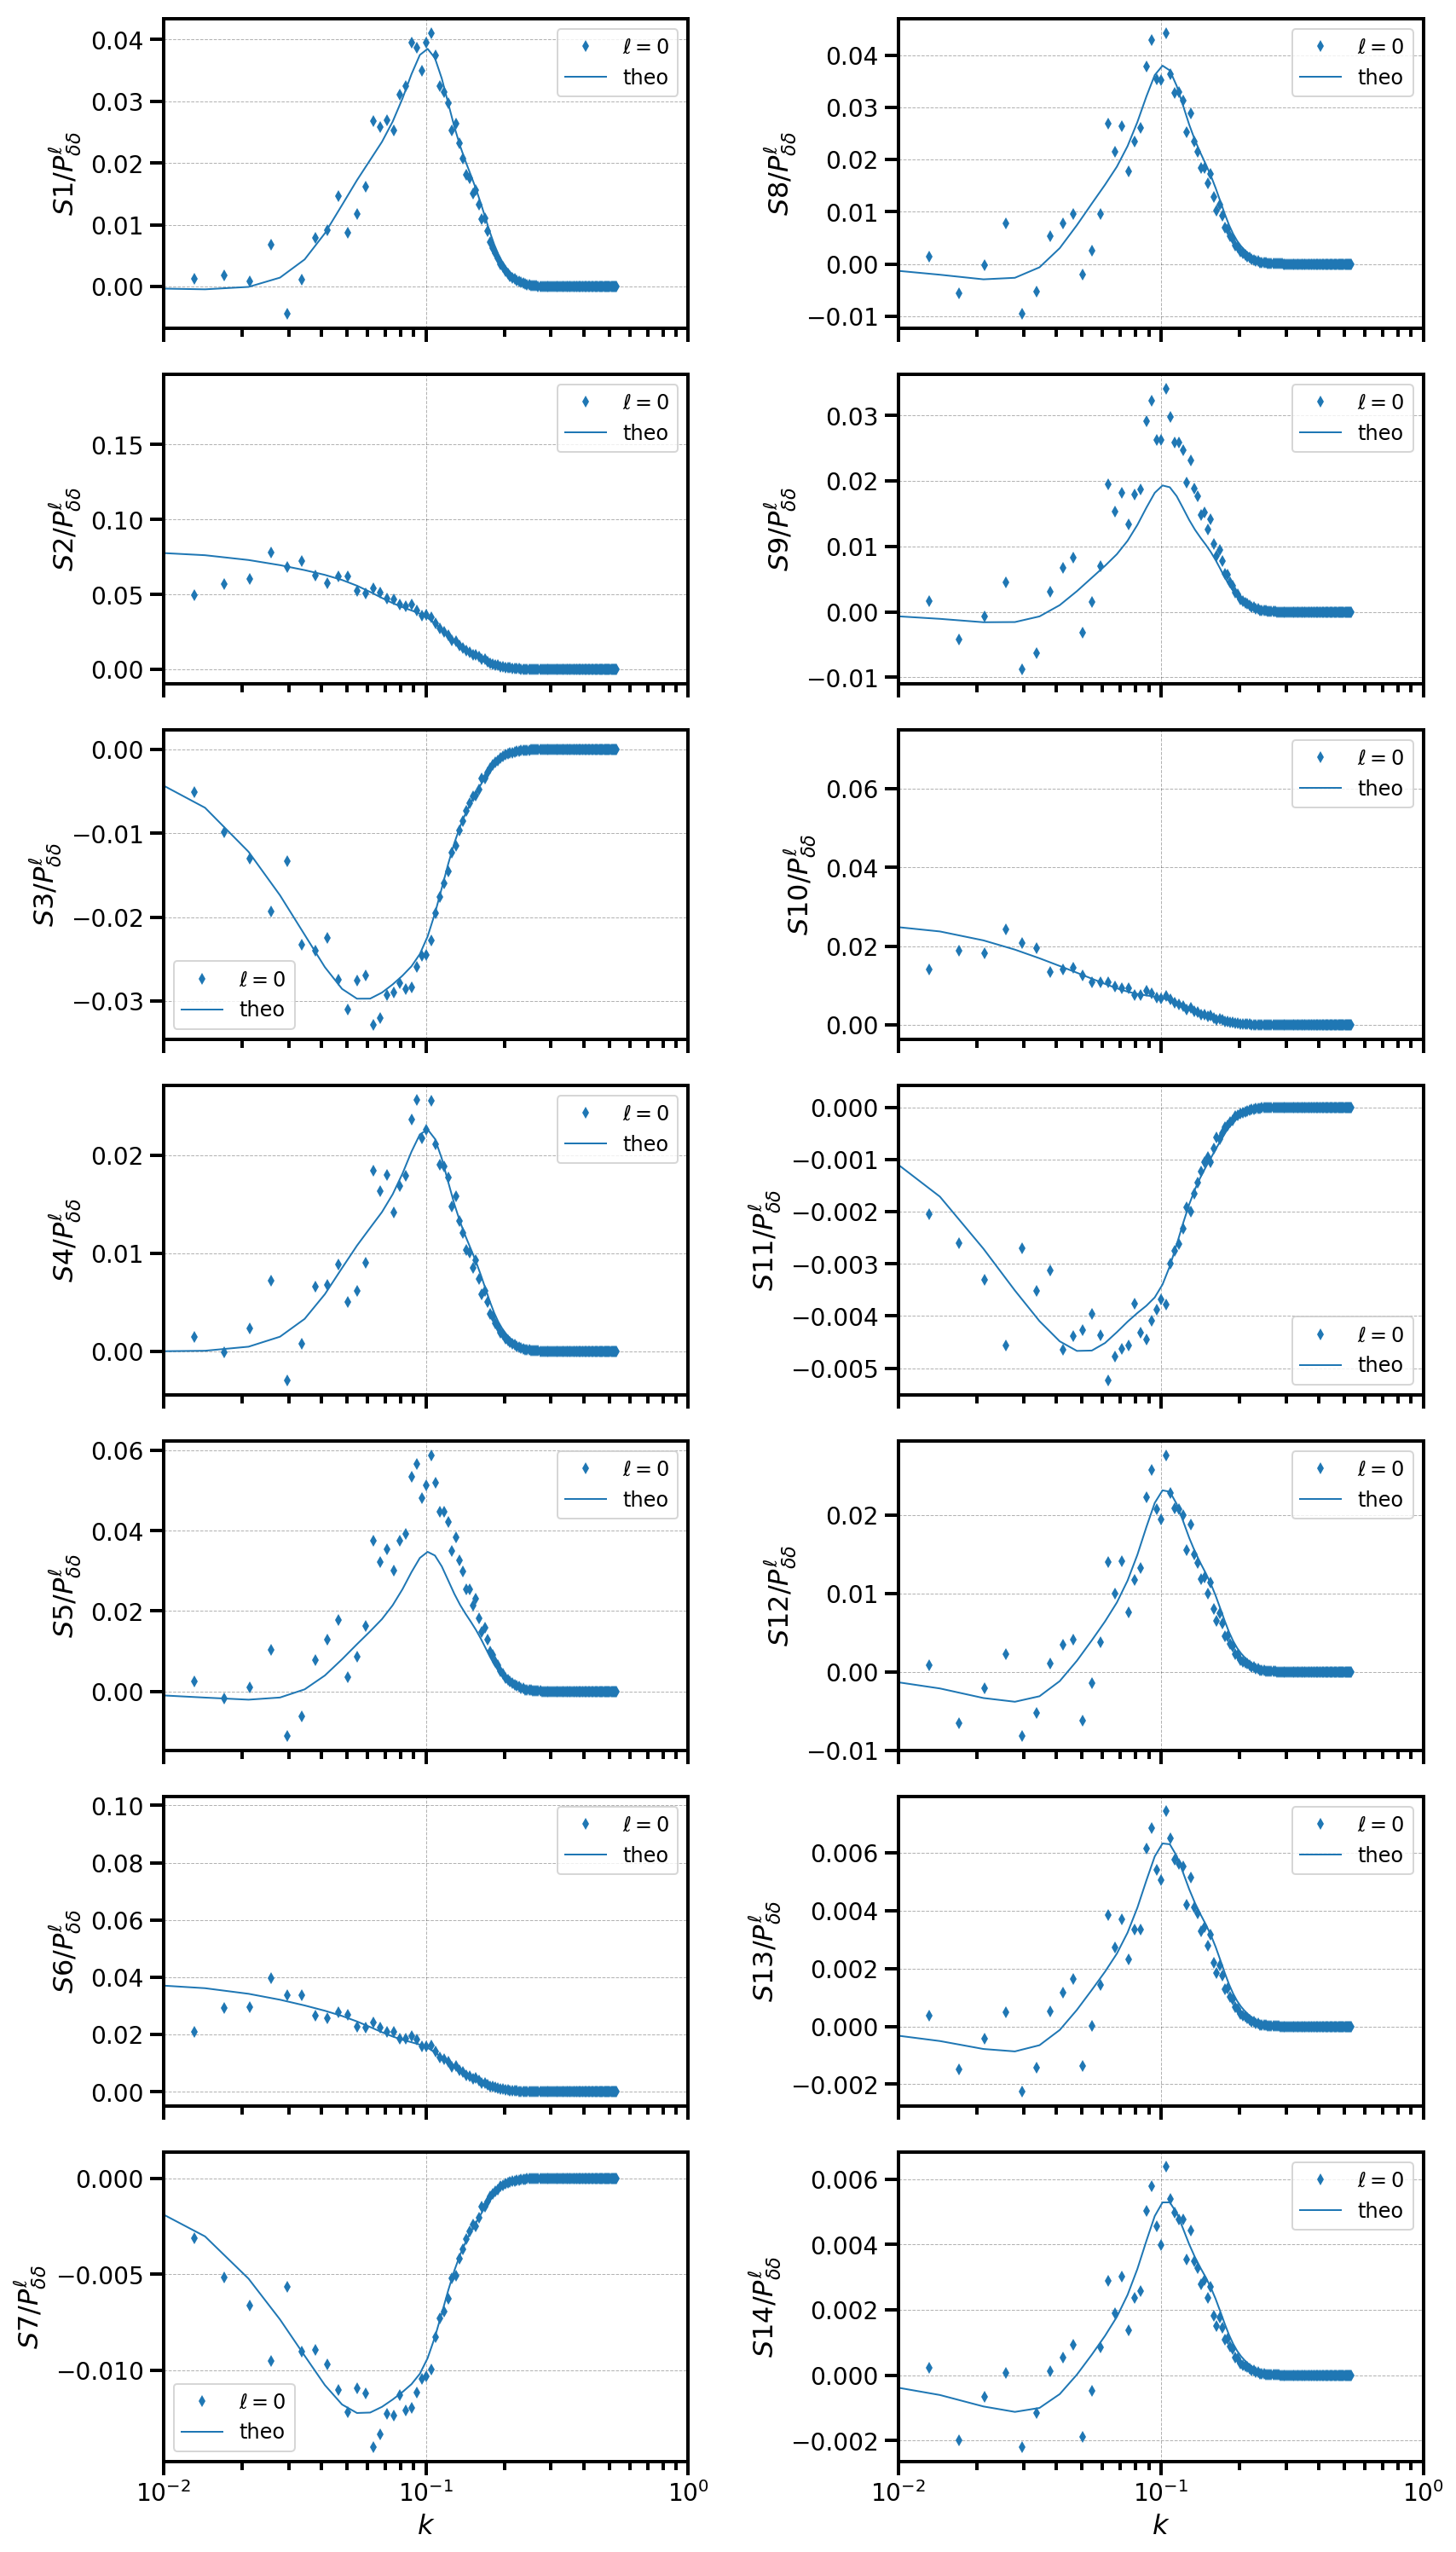

In [12]:
# plot Pskew/P_dd
APPLY_RSD = opts['APPLY_RSD']
boxsize = opts['boxsize']
fig, axarr = plt.subplots(7,2,figsize=(6*2,3*7), sharex=True)
kvec = Pdd.poles['k']
ww = np.where(kvec<=1.0)[0]
for counter,skew_spec in enumerate(skew_spectra):
    ax = axarr[counter%7,counter//7]

    for ell in [0]:        
        color = colors[ell]
        
        # plot measurements, divide by measured power
        if APPLY_RSD and False:
            ax.semilogx(kvec[ww], skew_spec.Pskew.poles['power_%d'%ell].real[ww]/Pdd.poles['power_%d'%ell].real[ww], marker='o', lw=0,
                         label=r'$\ell=%d$'%ell, color=color, markersize=5)

        
        # measurements divided by theory P_l
        if ell==0:
            if APPLY_RSD:
                denomi = interp_Ptheo_k_P0(kvec[ww])
            else:
                denomi = interp_Ptheo_k_Plin(kvec[ww])
            if compute_112_manually:
                Pmeas = sum(this_Pskew.poles['power_%d'%ell].real[ww] for this_Pskew in skew_spec.Pskew.values())
            else:
                Pmeas = skew_spec.Pskew['default_key'].poles['power_%d'%ell].real[ww]
            
            ax.semilogx(kvec[ww], Pmeas/denomi, marker='d', lw=0,
                         label=r'$\ell=%d$'%ell, color=color, markersize=5)
        
        # plot theory skew spectra 
        if APPLY_RSD:
            # S_n/Pl
            if skew_spec.name in Sn_rsd_theo[(ell,)].dtype.names:
                ax.semilogx(Sn_rsd_theo[(ell,)]['k'], Sn_rsd_theo[(ell,)][skew_spec.name], label='theo', color=color,
                    lw=1)
        else:
            # S_n/Plin
            if skew_spec.name+'p_lin' in Sn_real_theo.dtype.names:
                ax.semilogx(Sn_real_theo['k'], Sn_real_theo[skew_spec.name+'p_lin'], label='theo', color=color,
                    lw=1)

    # cosmetics
    ax.set_xlim((0.01,1))
    ax.legend(loc='best', ncol=1, fontsize=12)
    if APPLY_RSD:
        ax.set_ylabel(r'$%s/P^\ell_{\delta\delta}$' % skew_spec.name)
    else:
        ax.set_ylabel(r'$%s/P_\mathregular{lin}$' % skew_spec.name)
axarr[6,0].set_xlabel(r'$k$')
axarr[6,1].set_xlabel(r'$k$')
plt.tight_layout()

print('summands:', sum(1 for this_Pskew in skew_spec.Pskew))

if True:
    # save plot
    fname = '../pdf/skewV3_DM_L%g_R%.1f_Ng%d_RSD%d.pdf' % (boxsize, Rsmooth,Nmesh,int(APPLY_RSD))
    plt.savefig(fname)
    print('Made %s' % fname)

In [13]:
f

0.786295109993697